In [1]:
import os
import numpy as np
import cv2 as cv

import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

%matplotlib inline

from dense_correspondence.dataset.spartan_dataset_masked import SpartanDataset
dataset_config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence',
                                       'dataset', 'composite',
                                       'caterpillar_upright.yaml')

dataset_config = utils.getDictFromYamlFilename(dataset_config_filename)

dataset = SpartanDataset(debug=True, config=dataset_config)

Using SpartanDataset:
   - in train mode
   - number of scenes 11
   - total images:     2851


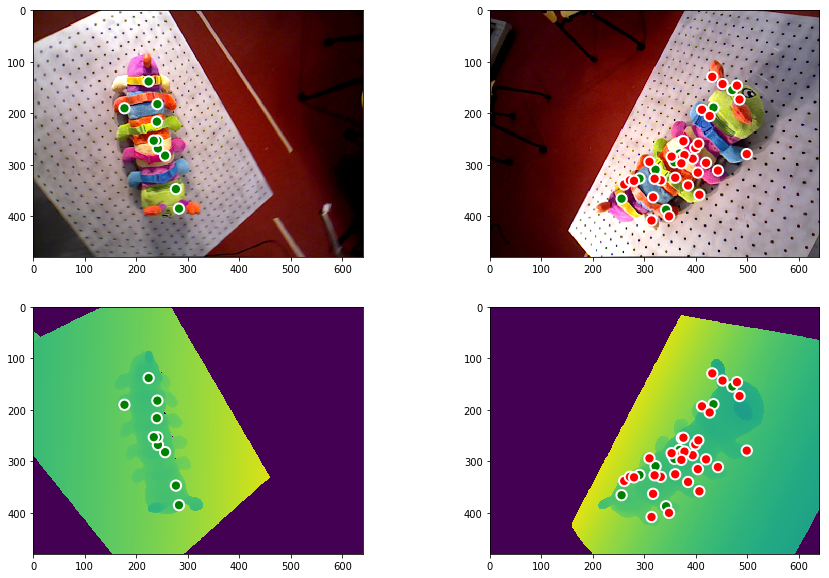

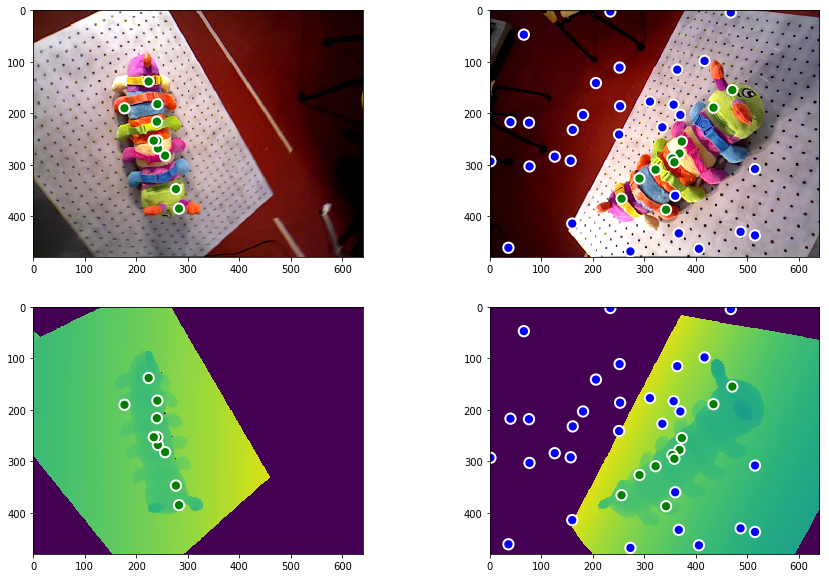

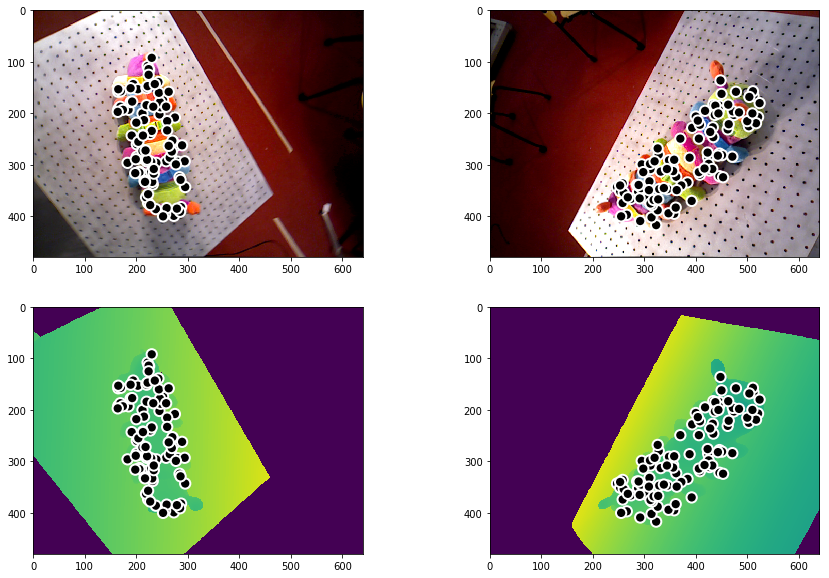

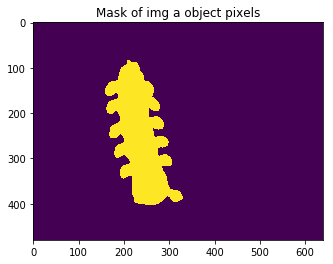

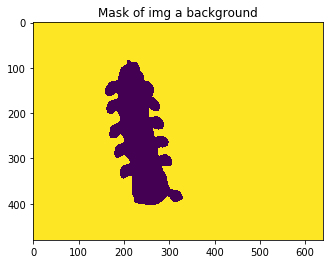

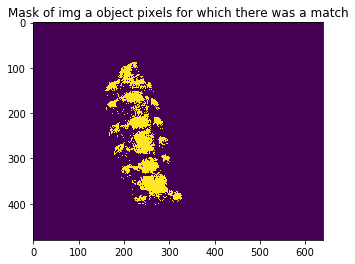

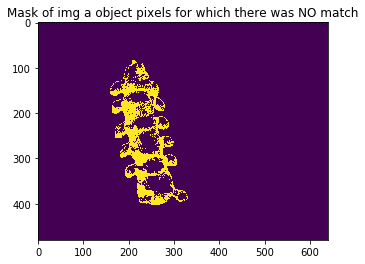

In [2]:
match_type, image_a_rgb, image_b_rgb, \
matches_a, matches_b, masked_non_matches_a, \
masked_non_matches_a, non_masked_non_matches_a, \
non_masked_non_matches_b, blind_non_matches_a, \
blind_non_matches_b, metadata = dataset.get_single_object_within_scene_data()

In [3]:
print(metadata)

{'image_a_idx': 2371, 'object_id': 'caterpillar', 'scene_name': '2018-04-16-14-40-25', 'object_id_int': 0, 'type': 0, 'image_b_idx': 2107}


In [4]:
image_a_rgb, image_a_depth, image_a_mask, image_a_pose = \
dataset.get_rgbd_mask_pose(metadata['scene_name'], metadata['image_a_idx'])
image_b_rgb, image_b_depth, image_b_mask, image_b_pose = \
dataset.get_rgbd_mask_pose(metadata['scene_name'], metadata['image_b_idx'])

In [44]:
image_a_pose

array([[ 0.76867368, -0.56216832,  0.30513532,  0.54310133],
       [-0.51653099, -0.82691683, -0.22227078,  0.17504215],
       [ 0.37727512,  0.01324185, -0.92600655,  0.76238891],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [45]:
image_b_pose

array([[-0.68998124, -0.38127459,  0.6152687 ,  0.35372912],
       [-0.46957901,  0.88265542,  0.02037058,  0.01162975],
       [-0.55083704, -0.27486195, -0.78805423,  0.57352948],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [48]:
quaternion_a_pose = utils.transformations.quaternion_from_matrix(image_a_pose)
print(quaternion_a_pose)

[ 0.0627501   0.93829594 -0.28740914  0.18182175]


In [49]:
quaternion_b_pose = utils.transformations.quaternion_from_matrix(image_b_pose)
print(quaternion_b_pose)

[ 0.31804872 -0.23206549  0.91660936 -0.06941108]


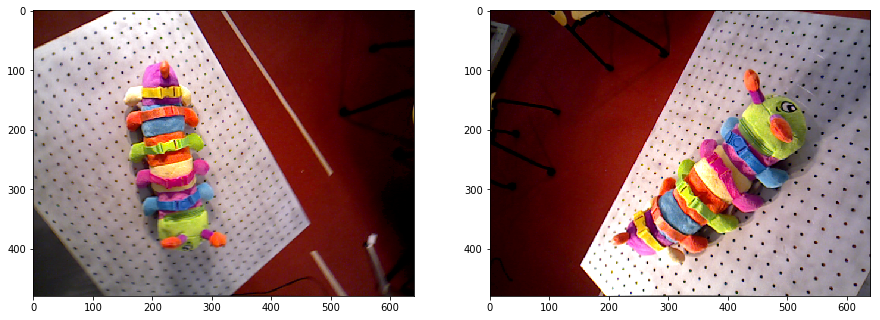

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].imshow(image_a_rgb)
axes[1].imshow(image_b_rgb)
plt.show()

In [6]:
matches_a = np.asarray(matches_a)
print(matches_a)

[ 56540  56541  56543 ... 257545 257546 257547]


In [7]:
matches_b = np.asarray(matches_b)
print(matches_b)

[251097 250452 249170 ... 102920 102280 101643]


TODO: use correspondence provided to calculate fundemental matrix using opencv

In [8]:
def unflaten_matches(matches, image_width=640):
    u_vec = (matches/image_width).astype(int)
    v_vec = matches % image_width
    
    return [[u,v] for u,v in zip(u_vec, v_vec)]

In [15]:
def downsample_matches(len_matches, num_samples=20):
    return np.random.choice(len_matches, num_samples)

In [16]:
select_indices = downsample_matches(len(matches_a))

In [41]:
matches_a_unfaltten = np.int32(unflaten_matches(matches_a))
matches_a_unfaltten_downsampled = matches_a_unfaltten[select_indices]

In [40]:
matches_b_unfaltten = np.int32(unflaten_matches(matches_b))
matches_b_unfaltten_downsampled = matches_b_unfaltten[select_indices]

In [24]:
F, mask = cv.findFundamentalMat(matches_a_unfaltten_downsampled,matches_b_unfaltten_downsampled,cv.FM_LMEDS)

In [26]:
F

array([[ 1.38444410e-06, -9.93022984e-07, -1.33888480e-03],
       [ 4.28865332e-07,  4.15330142e-07, -4.05396202e-04],
       [-1.06144236e-03, -1.28727913e-03,  1.00000000e+00]])

In [28]:
mask

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=uint8)

In [38]:
image_a_gray = cv.cvtColor(np.asarray(image_a_rgb), cv.COLOR_BGR2GRAY)
image_b_gray = cv.cvtColor(np.asarray(image_b_rgb), cv.COLOR_BGR2GRAY)
# plt.imshow(image_a_gray)

In [29]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

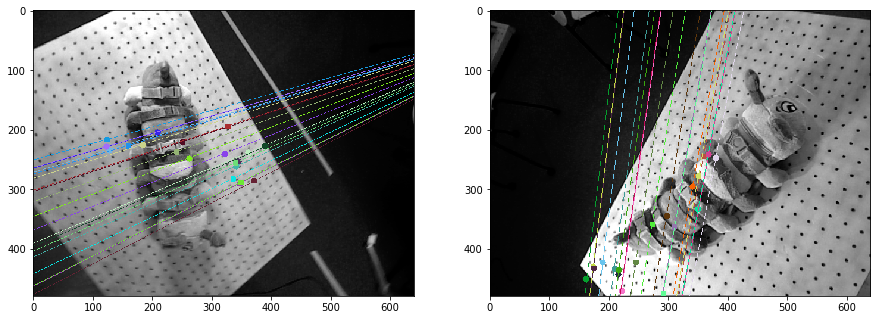

In [43]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv.computeCorrespondEpilines(matches_b_unfaltten_downsampled.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(image_a_gray,image_b_gray,\
                      lines1,matches_a_unfaltten_downsampled,matches_b_unfaltten_downsampled)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(matches_a_unfaltten_downsampled.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(image_b_gray,image_a_gray,\
                      lines2,matches_b_unfaltten_downsampled,matches_a_unfaltten_downsampled)
# plt.subplot(121),plt.imshow(img5)
# plt.subplot(122),plt.imshow(img3)

fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)
axes[0].imshow(img5)
axes[1].imshow(img3)

plt.show()